# Manutenção preditiva: Condição da Embarcação Naval

### Dataset: https://www.kaggle.com/datasets/thedevastator/improving-naval-vessel-condition-through-machine/data
### Recohecimento: https://data.world/uci

## Informações relevantes sobre o dataset
Posição da alavanca, velocidade do navio e medidas de GT em estado estacionário.

Antes de iniciar sua análise, é importante que você se familiarize com os diversos parâmetros incluídos neste conjunto de dados. 

Inclui 16 recursos relacionados às medidas GT (turbina a gás) da planta de propulsão de uma embarcação naval, juntamente com coeficientes de estado de decaimento para compressor e turbina GT. Isso inclui posição da alavanca, velocidade do navio, torque do eixo, taxa de rotações para GT e GG (gerador de gás), torques da hélice de estibordo e bombordo, medições de temperatura/pressão de saída da turbina, bem como taxa de fluxo de combustível, etc. - compreensão profunda de cada parâmetro antes de prosseguir com sua análise.

## Ideias para pesquisa

* Prever a queda futura do desempenho dos componentes para planejar atividades de manutenção eficientes e econômicas.
* Desenvolvimento de modelos preditivos para prever danos ou falhas em plantas de propulsão e, portanto, permitir a tomada de decisões de manutenção com base nas condições.
* Analisar o impacto que diferentes condições operacionais têm sobre vários componentes das plantas de propulsão naval e propor planos para maximizar a eficiência, garantindo ao mesmo tempo segurança e confiabilidade


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

sns.set_palette('pastel')

In [2]:
df = pd.read_csv('./dataset/data.csv', index_col=0).reset_index(drop=True)
df.head()

Lever position   Ship speed (v)   \
0            1.138                3   
1            2.088                6   
2            3.144                9   
3            4.161               12   
4            5.140               15   

   Gas Turbine (GT) shaft torque (GTT) [kN m]    \
0                                       289.964   
1                                      6960.180   
2                                      8379.229   
3                                     14724.395   
4                                     21636.432   

   GT rate of revolutions (GTn) [rpm]    \
0                              1349.489   
1                              1376.166   
2                              1386.757   
3                              1547.465   
4                              1924.313   

   Gas Generator rate of revolutions (GGn) [rpm]    \
0                                         6677.380   
1                                         6828.469   
2                                         7111.811   
3                                         7792.630   
4                                         8494.777   

   Starboard Propeller Torque (Ts) [kN]    Port Propeller Torque (Tp) [kN]    \
0                                   7.584                              7.584   
1                                  28.204                             28.204   
2                                  60.358                             60.358   
3                                 113.774                            113.774   
4                                 175.306                            175.306   

   Hight Pressure (HP) Turbine exit temperature (T48) [C]    \
0                                            464.006          
1                                            635.401          
2                                            606.002          
3                                            661.471          
4                                            731.494          

   GT Compressor inlet air temperature (T1) [C]    \
0                                             288   
1                                             288   
2                                             288   
3                                             288   
4                                             288   

   GT Compressor outlet air temperature (T2) [C]    \
0                                          550.563   
1                                          581.658   
2                                          587.587   
3                                          613.851   
4                                          645.642   

   HP Turbine exit pressure (P48) [bar]    \
0                                   1.096   
1                                   1.331   
2                                   1.389   
3                                   1.658   
4                                   2.078   

   GT Compressor inlet air pressure (P1) [bar]    \
0                                          0.998   
1                                          0.998   
2                                          0.998   
3                                          0.998   
4                                          0.998   

   GT Compressor outlet air pressure (P2) [bar]    \
0                                           5.947   
1                                           7.282   
2                                           7.574   
3                                           9.007   
4                                          11.197   

   GT exhaust gas pressure (Pexh) [bar]    \
0                                   1.019   
1                                   1.019   
2                                   1.020   
3                                   1.022   
4                                   1.026   

   Turbine Injecton Control (TIC) [%]    Fuel flow (mf) [kg/s]    \
0                                 7.137                    0.082   
1                                10.655                    0.28

Ajustando o nome das colunas para o português

In [3]:
df.columns = [
    'alavanca',
    'velocidade',
    'torque_gt_kN_m',
    'rotacoes_gt_rpm',
    'rotacoes_gg_rpm',
    'torque_boreste_kN',
    'torque_bombordo_kN',
    'temp_saida_hp_t48_C',
    'temp_entrada_ar_gt_t1_C',
    'temp_saida_ar_gt_t2_C',
    'pressao_saida_hp_p48_bar',
    'pressao_entrada_ar_gt_p1_bar',
    'pressao_saida_ar_gt_p2_bar',
    'pressao_gases_escape_pexh_bar',
    'controle_injecao_turbina_tic_pct',
    'fluxo_combustivel_mf_kg_s',
    'coef_decaimento_compressor_gt',
    'coef_decaimento_turbina_gt'
]

Criando um dicionario de descrição das features

In [4]:
titles = {
    'alavanca': 'Posição da alavanca de controle do navio.',
    'velocidade': 'Velocidade atual do navio.',
    'torque_gt_kN_m': 'Torque aplicado ao eixo da turbina a gás, medido em quilonewtons-metro.',
    'rotacoes_gt_rpm': 'Taxa de rotações por minuto da turbina a gás.',
    'rotacoes_gg_rpm': 'Taxa de rotações por minuto do gerador de gás.',
    'torque_boreste_kN': 'Torque aplicado à hélice de boreste, medido em quilonewtons.',
    'torque_bombordo_kN': 'Torque aplicado à hélice de bombordo, medido em quilonewtons.',
    'temp_saida_hp_t48_C': 'Temperatura do gás na saída da turbina de alta pressão, medida em graus Celsius.',
    'temp_entrada_ar_gt_t1_C': 'Temperatura do ar na entrada do compressor da turbina a gás, medida em graus Celsius.',
    'temp_saida_ar_gt_t2_C': 'Temperatura do ar na saída do compressor da turbina a gás, medida em graus Celsius.',
    'pressao_saida_hp_p48_bar': 'Pressão do gás na saída da turbina de alta pressão, medida em bar.',
    'pressao_entrada_ar_gt_p1_bar': 'Pressão do ar na entrada do compressor da turbina a gás, medida em bar.',
    'pressao_saida_ar_gt_p2_bar': 'Pressão do ar na saída do compressor da turbina a gás, medida em bar.',
    'pressao_gases_escape_pexh_bar': 'Pressão dos gases de escape da turbina a gás, medida em bar.',
    'controle_injecao_turbina_tic_pct': 'Controle de injeção da turbina, expresso como porcentagem.',
    'fluxo_combustivel_mf_kg_s': 'Fluxo de combustível, medido em quilogramas por segundo.',
    'coef_decaimento_compressor_gt': 'Coeficiente de decaimento do compressor da turbina a gás.',
    'coef_decaimento_turbina_gt': 'Coeficiente de decaimento da turbina a gás.'
}

In [5]:
df.head()

alavanca  velocidade  torque_gt_kN_m  rotacoes_gt_rpm  rotacoes_gg_rpm  \
0     1.138           3         289.964         1349.489         6677.380   
1     2.088           6        6960.180         1376.166         6828.469   
2     3.144           9        8379.229         1386.757         7111.811   
3     4.161          12       14724.395         1547.465         7792.630   
4     5.140          15       21636.432         1924.313         8494.777   

   torque_boreste_kN  torque_bombordo_kN  temp_saida_hp_t48_C  \
0              7.584               7.584              464.006   
1             28.204              28.204              635.401   
2             60.358              60.358              606.002   
3            113.774             113.774              661.471   
4            175.306             175.306              731.494   

   temp_entrada_ar_gt_t1_C  temp_saida_ar_gt_t2_C  pressao_saida_hp_p48_bar  \
0                      288                550.563                     1.096   
1                      288                581.658                     1.331   
2                      288                587.587                     1.389   
3                      288                613.851                     1.658   
4                      288                645.642                     2.078   

   pressao_entrada_ar_gt_p1_bar  pressao_saida_ar_gt_p2_bar  \
0                         0.998                       5.947   
1                         0.998                       7.282   
2                         0.998                       7.574   
3                         0.998                       9.007   
4                         0.998                      11.197   

   pressao_gases_escape_pexh_bar  controle_injecao_turbina_tic_pct  \
0                          1.019                             7.137   
1                          1.019                            10.655   
2                          1.020                            13.086   
3                          1.022                            18.109   
4                          1.026                            26.373   

   fluxo_combustivel_mf_kg_s  coef_decaimento_compressor_gt  \
0                      0.082                           0.95   
1                      0.287                           0.95   
2                      0.259                           0.95   
3                      0.358                           0.95   
4                      0.522                           0.95   

   coef_decaimento_turbina_gt  
0                       0.975  
1                       0.975  
2                       0.975  
3                       0.975  
4                       0.975

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   alavanca                          11934 non-null  float64
 1   velocidade                        11934 non-null  int64  
 2   torque_gt_kN_m                    11934 non-null  float64
 3   rotacoes_gt_rpm                   11934 non-null  float64
 4   rotacoes_gg_rpm                   11934 non-null  float64
 5   torque_boreste_kN                 11934 non-null  float64
 6   torque_bombordo_kN                11934 non-null  float64
 7   temp_saida_hp_t48_C               11934 non-null  float64
 8   temp_entrada_ar_gt_t1_C           11934 non-null  int64  
 9   temp_saida_ar_gt_t2_C             11934 non-null  float64
 10  pressao_saida_hp_p48_bar          11934 non-null  float64
 11  pressao_entrada_ar_gt_p1_bar      11934 non-null  float64
 12  pres

In [7]:
df.describe()

alavanca    velocidade  torque_gt_kN_m  rotacoes_gt_rpm  \
count  11934.000000  11934.000000    11934.000000     11934.000000   
mean       5.166667     15.000000    27247.498685      2136.289256   
std        2.626388      7.746291    22148.613155       774.083881   
min        1.138000      3.000000      253.547000      1307.675000   
25%        3.144000      9.000000     8375.883750      1386.758000   
50%        5.140000     15.000000    21630.659000      1924.326000   
75%        7.148000     21.000000    39001.426750      2678.079000   
max        9.300000     27.000000    72784.872000      3560.741000   

       rotacoes_gg_rpm  torque_boreste_kN  torque_bombordo_kN  \
count     11934.000000       11934.000000        11934.000000   
mean       8200.947312         227.335768          227.335768   
std        1091.315507         200.495889          200.495889   
min        6589.002000           5.304000            5.304000   
25%        7058.324000          60.317000           60.317000   
50%        8482.081500         175.268000          175.268000   
75%        9132.606000         332.364750          332.364750   
max        9797.103000         645.249000          645.249000   

       temp_saida_hp_t48_C  temp_entrada_ar_gt_t1_C  temp_saida_ar_gt_t2_C  \
count         11934.000000                  11934.0           11934.000000   
mean            735.495446                    288.0             646.215331   
std             173.680552                      0.0              72.675882   
min             442.364000                    288.0             540.442000   
25%             589.872750                    288.0             578.092250   
50%             706.038000                    288.0             637.141500   
75%             834.066250                    288.0             693.924500   
max            1115.797000                    288.0             789.094000   

       pressao_saida_hp_p48_bar  pressao_entrada_ar_gt_p1_bar  \
count              11934.000000                  1.193400e+04   
mean                   2.352963                  9.980000e-01   
std                    1.084770                  2.220539e-16   
min                    1.093000                  9.980000e-01   
25%                    1.389000                  9.980000e-01   
50%                    2.083000                  9.980000e-01   
75%                    2.981000                  9.980000e-01   
max                    4.560000                  9.980000e-01   

       pressao_saida_ar_gt_p2_bar  pressao_gases_escape_pexh_bar  \
count                11934.000000                   11934.000000   
mean                    12.297123                       1.029474   
std                      5.337448                       0.010390   
min                      5.828000                       1.019000   
25%                      7.447250                       1.020000   
50%                     11.092000                       1.026000   
75%                     15.658000                       1.036000   
max                     23.140000                       1.052000   

       controle_injecao_turbina_tic_pct  fluxo_combustivel_mf_kg_s  \
count                      11934.000000               11934.000000   
mean                          33.641261                   0.662440   
std                           25.841363                   0.507132   
min                            0.000000                   0.068000   
25%                           13.677500                   0.246000   
50%                           25.276500                   0.496000   
75%                           44.552500                   0.882000   
max                           92.556000                   1.832000   

       coef_decaimento_compressor_gt  coef_decaimento_turbina_gt  
count                    11934.00000                  11934.0000  
mean                         0.97500                      0.9875  
std                          0.01472                      0.

As feature `temp_entrada_ar_gt_t1_C` e `pressao_entrada_ar_gt_p1_bar` possuem valores constantes, então no agregam na análise e serão removidas

In [8]:
drop_columns  = ['temp_entrada_ar_gt_t1_C', 'pressao_entrada_ar_gt_p1_bar']
df.drop(columns=drop_columns, inplace=True)

Analisando a distribuição dos dados e se existem outliers

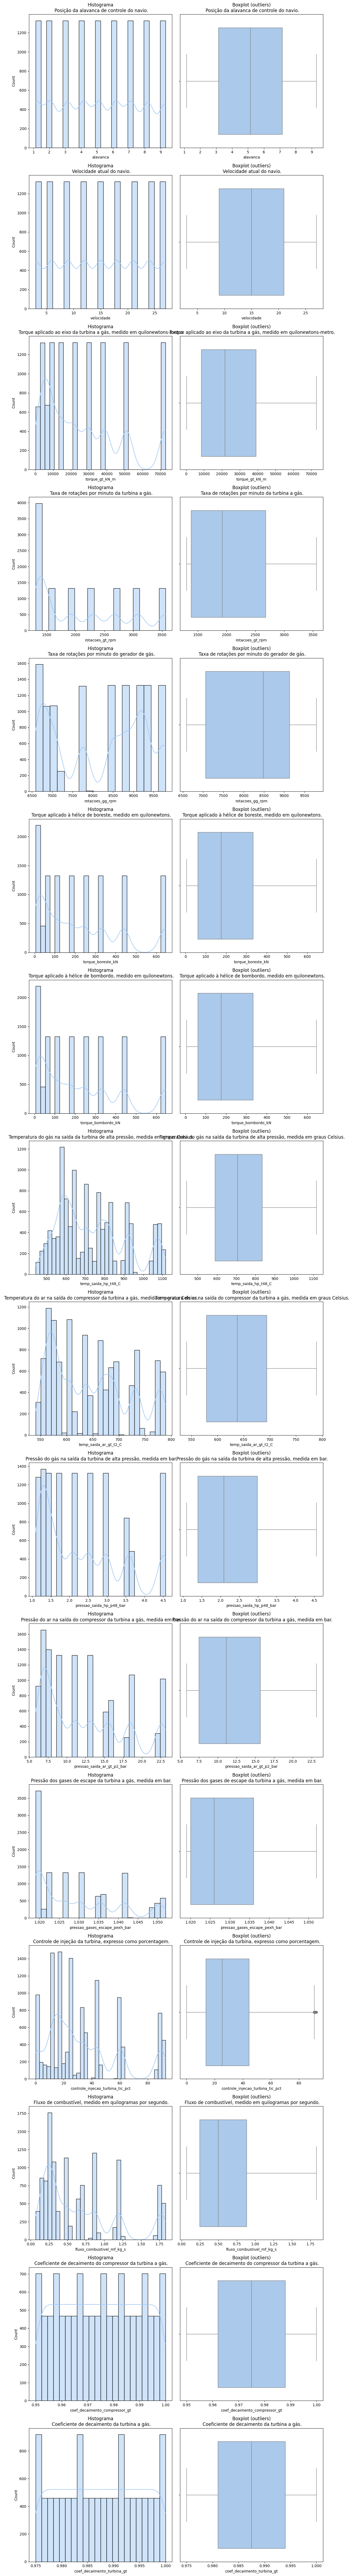

In [9]:
fig, ax = plt.subplots(nrows=len(df.columns), ncols=2, figsize=(12, 6 * len(df.columns)))
for i, column in enumerate(df.columns):
    
    ax[i, 0].set_title(f'Histograma\n {titles[column]}')
    sns.histplot(data=df, x=column, kde=True, ax=ax[i, 0])

    ax[i, 1].set_title(f'Boxplot (outliers)\n {titles[column]}')
    sns.boxplot(data=df, x=column, ax=ax[i, 1])
    plt.tight_layout()
    
plt.show()

Visão macro da dispersão dos dados entre variaveis

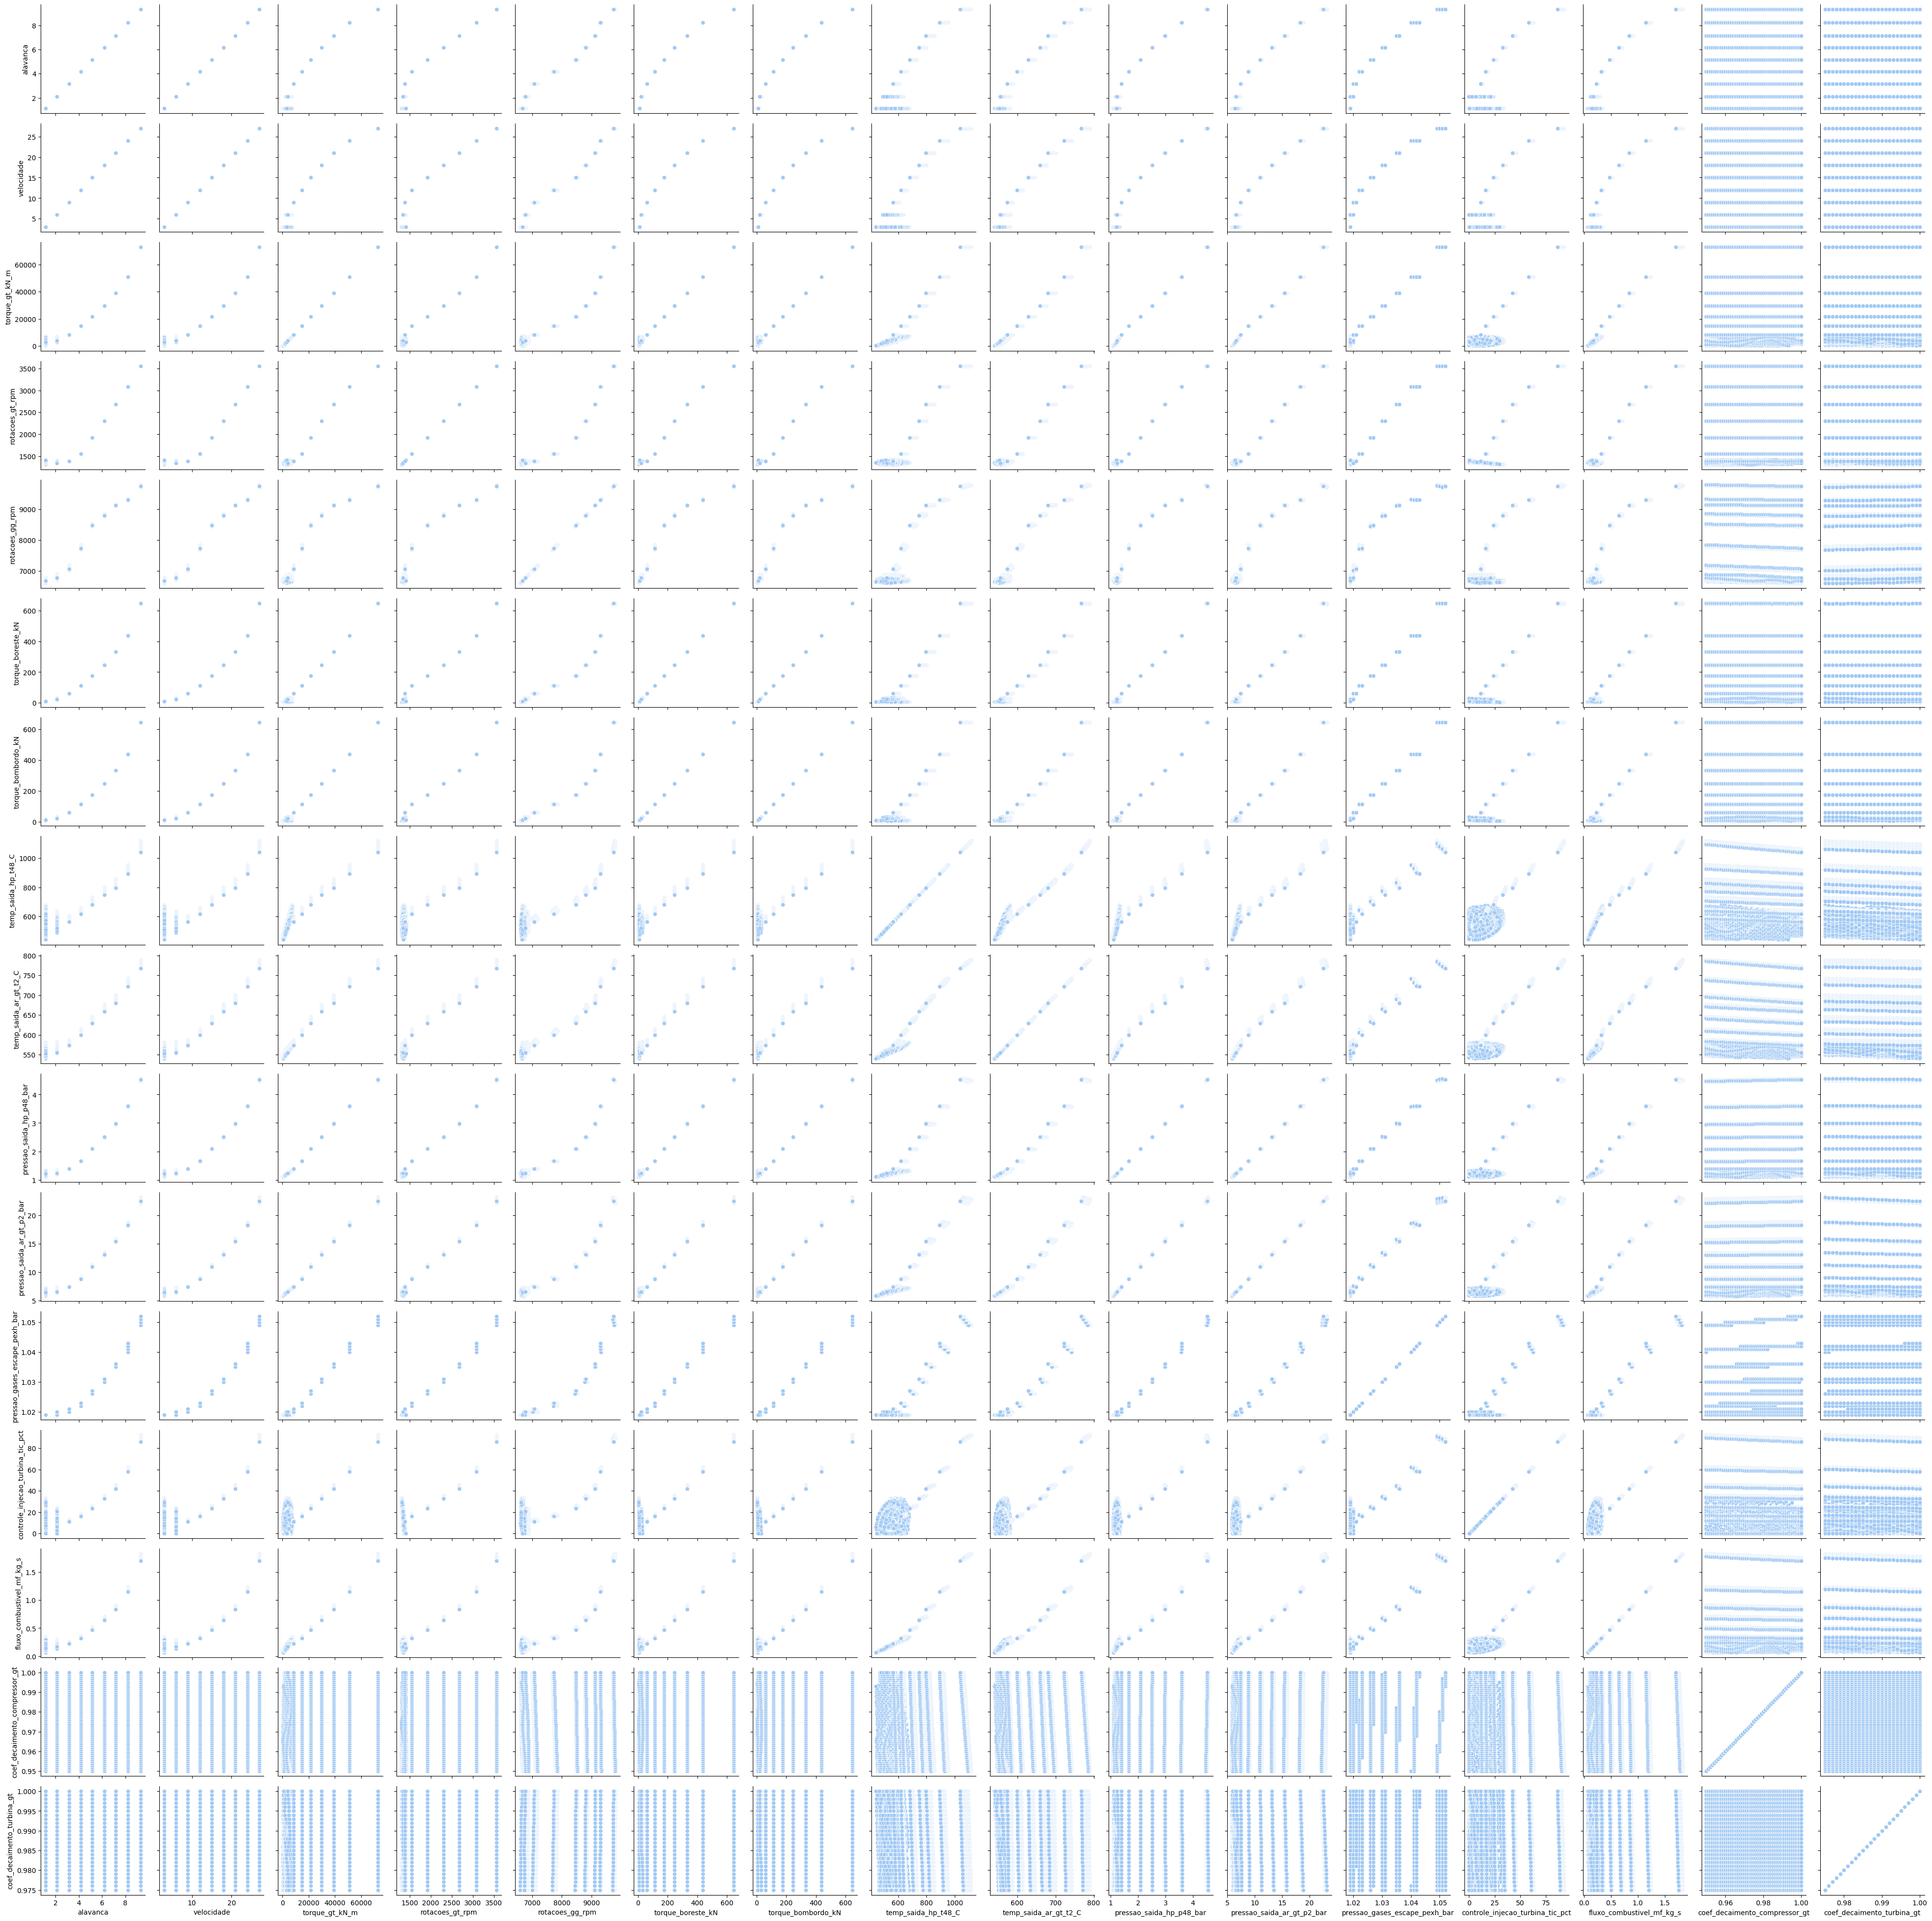

In [10]:
grid = sns.PairGrid(df)
grid.map(sns.scatterplot)

Identificando a correlação dos dados

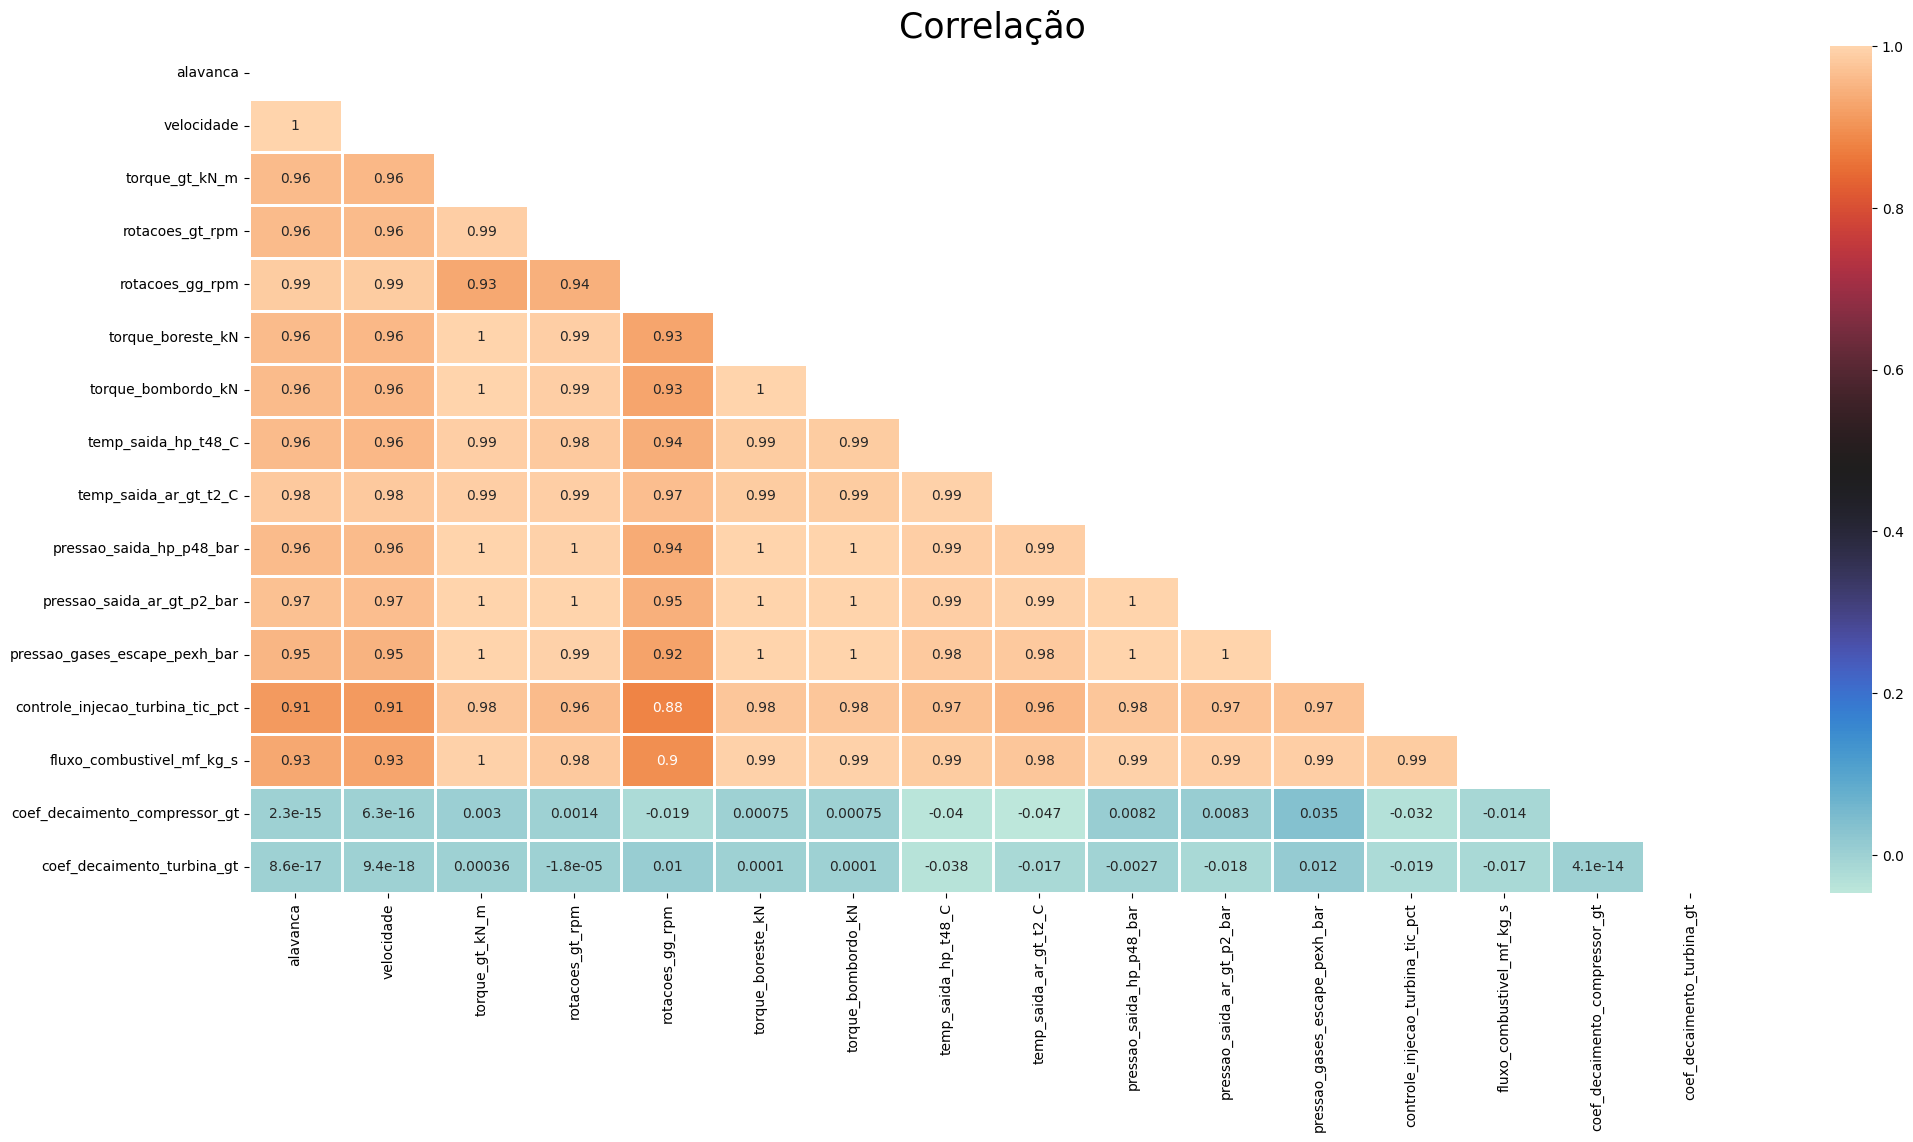

In [11]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(24,11))
plt.title('Correlação', fontsize=25)
sns.heatmap(corr, cbar=True, cmap='icefire', annot=True, linewidths=1, mask=mask, ax=ax)
plt.show()

A **multicolinearidade** entre **variáveis independentes** ocorre quando duas ou mais dessas variáveis estão altamente correlacionadas, o que pode dificultar a interpretação e o desempenho de modelos estatísticos. Isso pode levar a coeficientes de regressão imprecisos, tornar as variáveis menos robustas e dificultar a identificação do impacto individual de cada variável sobre a variável dependente. Em essência, a multicolinearidade prejudica a capacidade do modelo de discernir as contribuições individuais das variáveis independentes, afetando a confiabilidade das inferências estatísticas.

### Feature engineering

Vamos criar algumas novas features que resumam esses valores em um unico valor e assim remova o problema da multicolineariedade.

#### Novas Variáveis Criadas:

1. **power_total:**
   - *Fórmula:* $( \frac{\text{velocidade} \times \text{torque}_{\text{gt}}}{\text{rotacoes}_{\text{gt}}} )$
   - *Descrição:* Potência total do sistema.

2. **system_efficiency:**
   - *Fórmula:* $( \frac{\text{power}_{\text{total}}}{\text{fluxo\_combustivel}} )$
   - *Descrição:* Eficiência do sistema.

3. **total_pressure:**
   - *Fórmula:* $( \text{pressao\_saida\_ar\_gt} + \text{pressao\_saida\_hp} )$
   - *Descrição:* Pressão total do sistema.

4. **average_temperature:**
   - *Fórmula:* $( \frac{\text{temp\_saida\_ar\_gt} + \text{temp\_saida\_hp}}{2} )$
   - *Descrição:* Temperatura média do sistema.

5. **total_propeller_torque:**
   - *Fórmula:* $( \text{torque}_{\text{boreste}} + \text{torque}_{\text{bombordo}} )$
   - *Descrição:* Torque total das hélices.

6. **thermal_load:**
   - *Fórmula:* $( \text{fluxo\_combustivel} \times (\text{temp\_saida\_hp} - \text{temp\_saida\_ar\_gt}) \times \text{pressao\_gases\_escape} )$
   - *Descrição:* Carga térmica do sistema.

<!-- 7. **specific_power:**
   - *Fórmula:* $( \frac{\text{power}_{\text{total}}}{\text{peso\_navio}} )$
   - *Descrição:* Potência específica do sistema. -->

7. **propeller_rpm_difference:**
   - *Fórmula:* $( \text{rotacoes}_{\text{gt}} - \text{rotacoes}_{\text{gg}} )$
   - *Descrição:* Diferença de rotações das hélices.

8. **temperature_difference:**
   - *Fórmula:* $( \text{temp\_saida\_hp} - \text{temp\_saida\_ar\_gt} )$
   - *Descrição:* Diferença de temperatura do sistema.

9. **fuel_efficiency:**
    - *Fórmula:* $( \frac{\text{velocidade}}{\text{fluxo\_combustivel}} )$
    - *Descrição:* Eficiência do combustível.

10. **total_torque:**
    - *Fórmula:* $( \text{torque}_{\text{gt}} + \text{torque}_{\text{boreste}} + \text{torque}_{\text{bombordo}} )$
    - *Descrição:* Torque total do sistema.

11. **pressure_temperature_ratio:**
    - *Fórmula:* $( \frac{\text{pressao\_saida\_ar\_gt}}{\text{temp\_saida\_ar\_gt}} )$
    - *Descrição:* Relação entre pressão e temperatura.


12. **Razão entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina:**
   - *Fórmula:* $( \frac{\text{coef\_decaimento\_compressor\_gt}}{\text{coef\_decaimento\_turbina\_gt}} )$
   - *Descrição:* Indica desequilíbrios entre o desgaste do compressor e da turbina.

13. **Produto entre Coeficiente de Decaimento do Compressor e Potência Total Normalizada pela Velocidade:**
   - *Fórmula:* $( \text{coef\_decaimento\_compressor\_gt} \times \frac{\text{power\_total}}{\text{velocidade}} )$
   - *Descrição:* Destaca a relação direta entre o desempenho do compressor, potência total e velocidade.

14. **Diferença Absoluta entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina:**
   - *Fórmula:* $( |\text{coef\_decaimento\_compressor\_gt} - \text{coef\_decaimento\_turbina\_gt}| )$
   - *Descrição:* Sinaliza discrepâncias inesperadas no desgaste entre compressor e turbina.

15. **Média Ponderada entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, Ponderada pela Potência Específica:**
   - *Fórmula:* $( \frac{\text{coef\_decaimento\_compressor\_gt} \times \text{specific\_power} + \text{coef\_decaimento\_turbina\_gt}}{\text{specific\_power} + 1} )$
   - *Descrição:* Média ponderada considerando a potência específica, oferecendo uma visão refinada da relação entre coeficientes e eficiência.

16. **Diferença Normalizada entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, Normalizada pela Velocidade:**
   - *Fórmula:* $( \frac{\text{coef\_decaimento\_compressor\_gt} - \text{coef\_decaimento\_turbina\_gt}}{\text{velocidade} + 1} )$
   - *Descrição:* Diferença normalizada considerando a influência da velocidade do navio.


Criação do dicionario de descrição das novas features

In [12]:
titles_features = {
    'power_total': 'Potência total do sistema, calculada a partir da velocidade, torque da turbina a gás e taxa de rotações.',
    'system_efficiency': 'Eficiência do sistema, indicando a relação entre a potência total e o fluxo de combustível.',
    'total_pressure': 'Pressão total do sistema, obtida somando as pressões de saída do compressor e da turbina de alta pressão.',
    'average_temperature': 'Temperatura média do sistema, calculada como a média das temperaturas de saída do compressor e da turbina de alta pressão.',
    'total_propeller_torque': 'Torque total das hélices, resultado da soma dos torques das hélices de boreste e bombordo.',
    'thermal_load': 'Carga térmica do sistema, considerando o fluxo de combustível, a diferença de temperatura e a pressão dos gases de escape.',
    'specific_power': 'Potência específica do sistema, representando a potência ajustada pelo peso do navio.',
    'propeller_rpm_difference': 'Diferença nas taxas de rotações das hélices de boreste e bombordo.',
    'temperature_difference': 'Diferença de temperatura entre a saída da turbina de alta pressão e a saída do compressor da turbina a gás.',
    'fuel_efficiency': 'Eficiência do combustível, representando a relação entre a velocidade e o fluxo de combustível.',
    'total_torque': 'Torque total do sistema, soma dos torques da turbina a gás, hélice de boreste e hélice de bombordo.',
    'pressure_temperature_ratio': 'Relação entre pressão e temperatura na saída do compressor da turbina a gás.',
    'ratio_decay_compressor_turbine': 'Razão entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, indicando desequilíbrios no desgaste.',
    'product_decay_compressor_power_normalized': 'Produto entre Coeficiente de Decaimento do Compressor e Potência Total Normalizada pela Velocidade, destacando a relação entre desempenho do compressor, potência total e velocidade.',
    'abs_diff_decay_compressor_turbine': 'Diferença Absoluta entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, sinalizando discrepâncias inesperadas no desgaste.',
    'weighted_avg_decay_compressor_turbine_power_specific': 'Média Ponderada entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, Ponderada pela Potência Específica, oferecendo uma visão refinada da relação entre coeficientes e eficiência.',
    'normalized_diff_decay_compressor_turbine_velocity': 'Diferença Normalizada entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina, Normalizada pela Velocidade, considerando a influência da velocidade do navio.'
}

Computação das novas features com base nas features bases do dataset

In [ ]:
df_feature = pd.DataFrame(index=df.index)
df_feature.loc[df.index,'power_total'] = (df['velocidade'] * df['torque_gt_kN_m']) / df['rotacoes_gt_rpm']
df_feature.loc[df.index,'system_efficiency'] = df_feature['power_total'] / df['fluxo_combustivel_mf_kg_s']
df_feature.loc[df.index,'total_pressure'] = df['pressao_saida_ar_gt_p2_bar'] + df['pressao_saida_hp_p48_bar']
df_feature.loc[df.index,'average_temperature'] = (df['temp_saida_ar_gt_t2_C'] + df['temp_saida_hp_t48_C']) / 2
df_feature.loc[df.index,'total_propeller_torque'] = df['torque_boreste_kN'] + df['torque_bombordo_kN']
df_feature.loc[df.index,'thermal_load'] = df['fluxo_combustivel_mf_kg_s'] * (df['temp_saida_hp_t48_C'] - df['temp_saida_ar_gt_t2_C']) * df['pressao_gases_escape_pexh_bar']
#df_feature.loc[df.index,'specific_power'] = df_feature['power_total'] / df['peso_do_navio']
df_feature.loc[df.index,'propeller_rpm_difference'] = df['rotacoes_gt_rpm'] - df['rotacoes_gg_rpm']
df_feature.loc[df.index,'temperature_difference'] = df['temp_saida_hp_t48_C'] - df['temp_saida_ar_gt_t2_C']
df_feature.loc[df.index,'fuel_efficiency'] = df['velocidade'] / df['fluxo_combustivel_mf_kg_s']
df_feature.loc[df.index,'total_torque'] = df['torque_gt_kN_m'] + df['torque_boreste_kN'] + df['torque_bombordo_kN']
df_feature.loc[df.index,'pressure_temperature_ratio'] = df['pressao_saida_ar_gt_p2_bar'] / df['temp_saida_ar_gt_t2_C']
df_feature.loc[df.index,'ratio_decay_compressor_turbine'] = df['coef_decaimento_compressor_gt'] / df['coef_decaimento_turbina_gt']
df_feature.loc[df.index,'product_decay_compressor_power_normalized'] = df['coef_decaimento_compressor_gt'] * (df_feature['power_total'] / df['velocidade'])
df_feature.loc[df.index,'abs_diff_decay_compressor_turbine'] = abs(df['coef_decaimento_compressor_gt'] - df['coef_decaimento_turbina_gt'])
#df_feature['weighted_avg_decay_compressor_turbine_power_specific'] = (df['coef_decaimento_compressor_gt'] * df['specific_power'] + df['coef_decaimento_turbina_gt']) / (df['specific_power'] + 1)
df_feature.loc[df.index,'normalized_diff_decay_compressor_turbine_velocity'] = (df['coef_decaimento_compressor_gt'] - df['coef_decaimento_turbina_gt']) / (df['velocidade'] + 1)


In [14]:
df_feature.head()

power_total  system_efficiency  total_pressure  average_temperature  \
0     0.644608           7.861079           7.043             507.2845   
1    30.345961         105.735056           8.613             608.5295   
2    54.380876         209.964774           8.963             596.7945   
3   114.182059         318.944299          10.665             637.6610   
4   168.655764         323.095334          13.275             688.5680   

   total_propeller_torque  thermal_load  propeller_rpm_difference  \
0                  15.168     -7.232530                 -5327.891   
1                  56.408     15.717302                 -5452.303   
2                 120.716      4.864875                 -5725.054   
3                 227.548     17.423015                 -6245.165   
4                 350.612     45.979927                 -6570.464   

   temperature_difference  fuel_efficiency  total_torque  \
0                 -86.557        36.585366       305.132   
1                  53.743        20.905923      7016.588   
2                  18.415        34.749035      8499.945   
3                  47.620        33.519553     14951.943   
4                  85.852        28.735632     21987.044   

   pressure_temperature_ratio  ratio_decay_compressor_turbine  \
0                    0.010802                        0.974359   
1                    0.012519                        0.974359   
2                    0.012890                        0.974359   
3                    0.014673                        0.974359   
4                    0.017342                        0.974359   

   product_decay_compressor_power_normalized  \
0                                   0.204126   
1                                   4.804777   
2                                   5.740204   
3                                   9.039413   
4                                  10.681532   

   abs_diff_decay_compressor_turbine  \
0                              0.025   
1                              0.025   
2                              0.025   
3                              0.025   
4                              0.025   

   normalized_diff_decay_compressor_turbine_velocity  
0                                          -0.006250  
1                                          -0.003571  
2                                          -0.002500  
3                                          -0.001923  
4                                          -0.001563

In [15]:
df_feature.describe()

power_total  system_efficiency  total_pressure  average_temperature  \
count  11934.000000       11934.000000    11934.000000         11934.000000   
mean     205.686339         264.535611       14.650086           690.855389   
std      174.270264         111.341080        6.421678           122.980993   
min        0.567797           6.988581        6.924000           491.403000   
25%       54.359894         220.070751        8.837000           584.042125   
50%      168.609538         328.768406       13.175000           671.621000   
75%      305.831001         341.569584       18.635000           763.794875   
max      551.938759         366.726172       27.700000           952.445500   

       total_propeller_torque  thermal_load  propeller_rpm_difference  \
count            11934.000000  11934.000000              11934.000000   
mean               454.671536    114.852599              -6064.658056   
std                400.991779    172.287982                443.706285   
min                 10.608000     -8.433954              -6593.338000   
25%                120.634000      2.689804              -6454.524000   
50%                350.536000     35.066452              -6213.866000   
75%                664.729500    128.722201              -5671.584500   
max               1290.498000    627.847371              -5221.092000   

       temperature_difference  fuel_efficiency  total_torque  \
count            11934.000000     11934.000000  11934.000000   
mean                89.280115        26.872541  27702.170222   
std                101.961451         8.283074  22549.280662   
min                -98.222000         8.875740    267.547000   
25%                 10.821000        20.236088   8496.517500   
50%                 70.062000        26.509573  21981.202000   
75%                140.975000        34.782609  39666.143750   
max                326.703000        48.780488  74075.284000   

       pressure_temperature_ratio  ratio_decay_compressor_turbine  \
count                11934.000000                    11934.000000   
mean                     0.018371                        0.987399   
std                      0.005888                        0.016688   
min                      0.010658                        0.950000   
25%                      0.012837                        0.974516   
50%                      0.017409                        0.987346   
75%                      0.022725                        1.000000   
max                      0.029990                        1.025641   

       product_decay_compressor_power_normalized  \
count                               11934.000000   
mean                                   10.512949   
std                                     5.602796   
min                                     0.180181   
25%                                     5.813070   
50%                                    10.959628   
75%                                    14.387292   
max                                    20.440156   

       abs_diff_decay_compressor_turbine  \
count                       11934.000000   
mean                            0.016912   
std                             0.011965   
min                             0.000000   
25%                             0.007000   
50%                             0.015000   
75%                             0.025000   
max                             0.050000   

       normalized_diff_decay_compressor_turbine_velocity  
count                                       11934.000000  
mean                                           -0.001120  
std                                             0.002003  
min                                            -0.012500  
25%                                            -0.001727  
50%                                            -0.000779  
75%                                             0.000000  
max                                             0.006250

Analisando as novas features para validar a distribuição dos dados e a presença de outliers

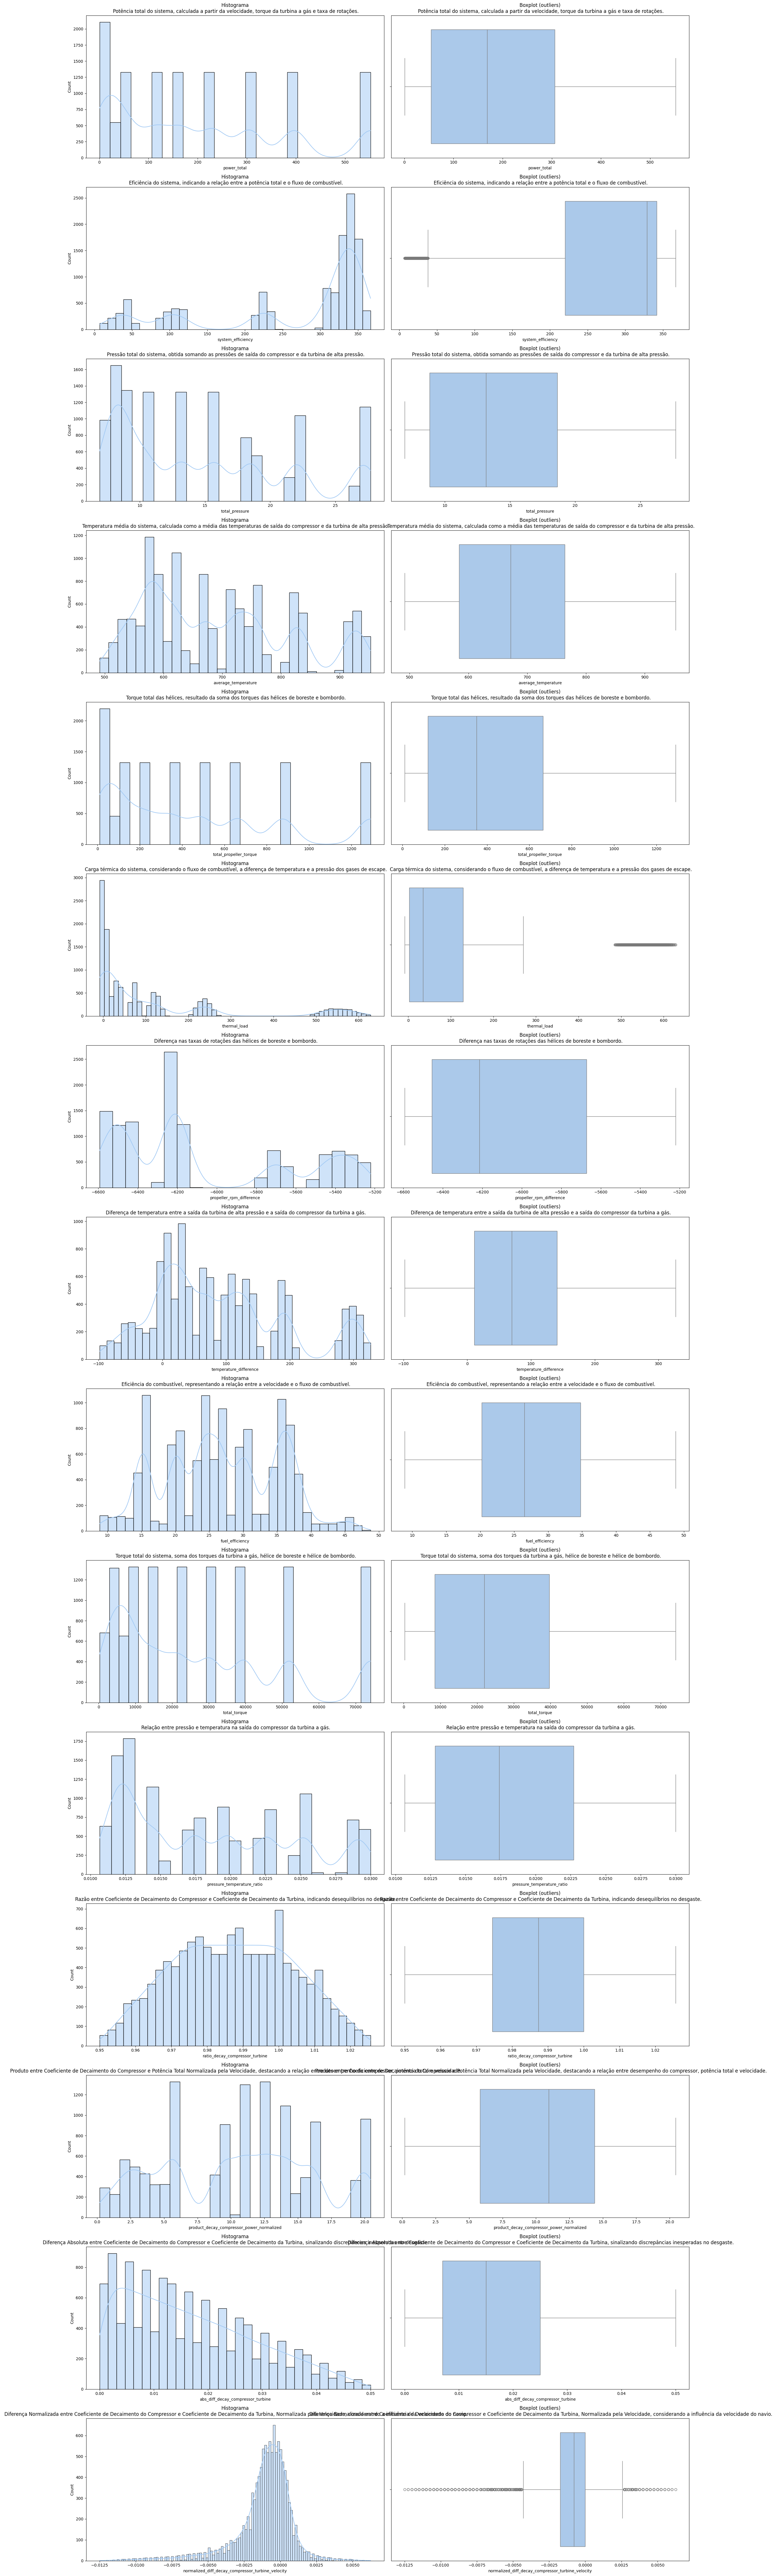

In [16]:
fig, ax = plt.subplots(nrows=len(df_feature.columns), ncols=2, figsize=(22, 6 * len(df_feature.columns)))
for i, column in enumerate(df_feature.columns):
    
    ax[i, 0].set_title(f'Histograma\n {titles_features[column]}')
    sns.histplot(data=df_feature, x=column, kde=True, ax=ax[i, 0])

    ax[i, 1].set_title(f'Boxplot (outliers)\n {titles_features[column]}')
    sns.boxplot(data=df_feature, x=column, ax=ax[i, 1])
    plt.tight_layout()
    
plt.show()

Visualizando a dispersão dos dados com base no cruzamento das features geradas

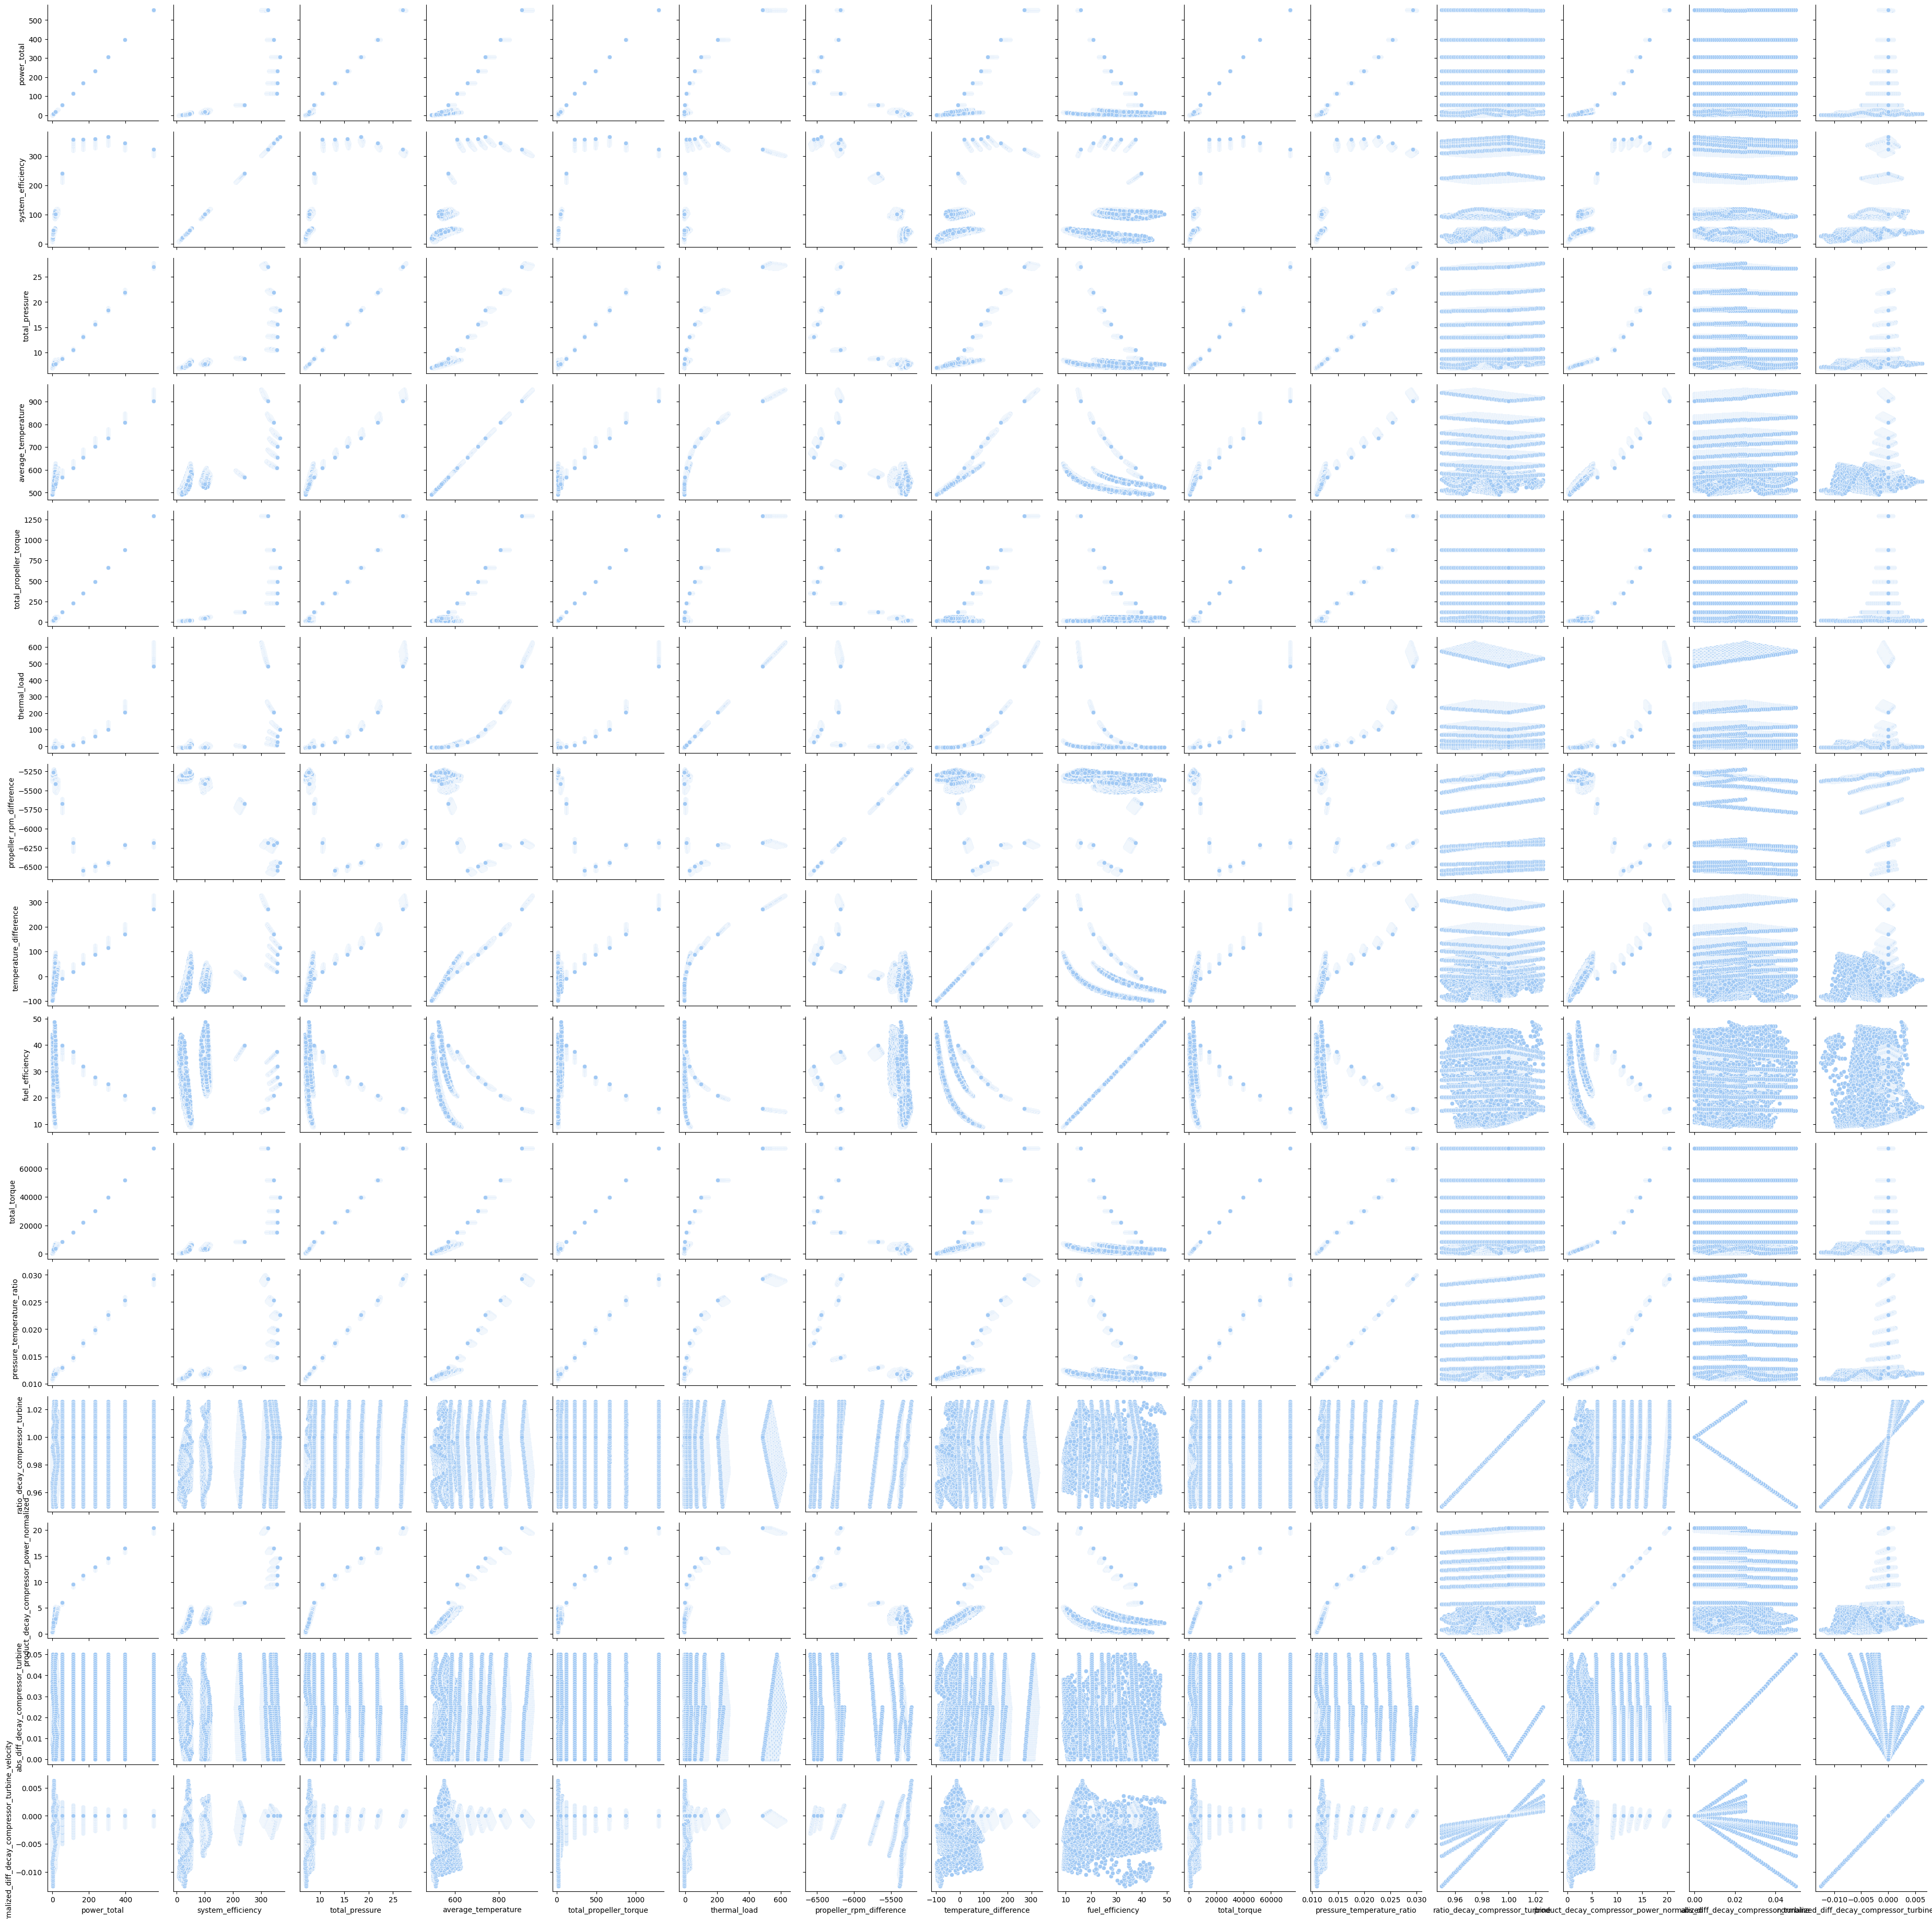

In [17]:
grid = sns.PairGrid(df_feature)
grid.map(sns.scatterplot)

Validando a correção das novas features

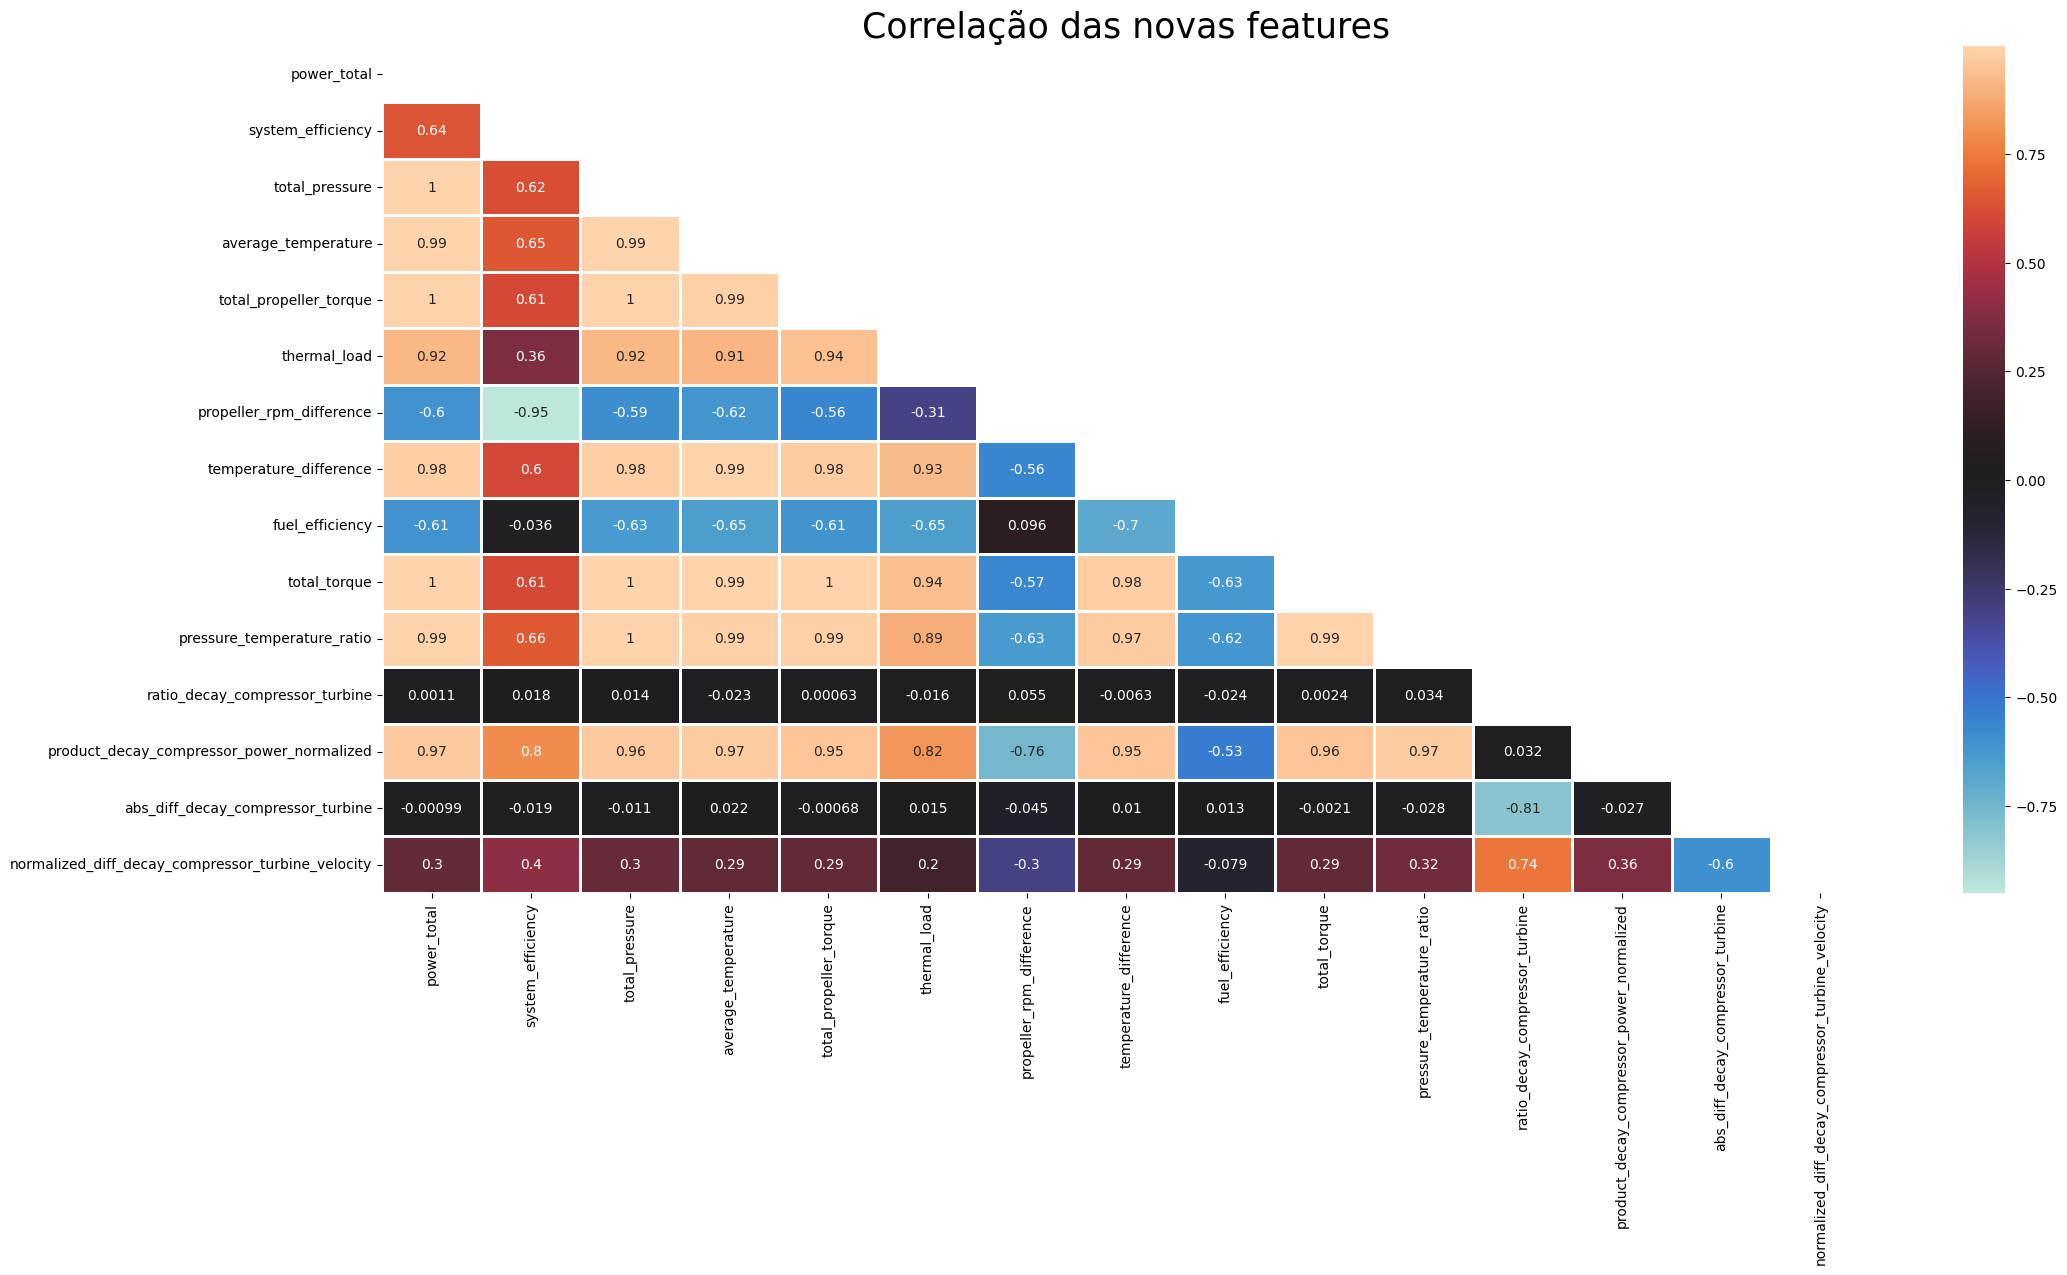

In [18]:
corr = df_feature.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(24,11))
plt.title('Correlação das novas features', fontsize=25)
sns.heatmap(corr, cbar=True, cmap='icefire', annot=True, linewidths=1, mask=mask, ax=ax)
plt.show()

#### Análise preditiva

## Prever a queda futura do desempenho dos componentes para planejar atividades de manutenção eficientes e econômicas.

Vamos utilizar como variavel alvo a variavel `abs_diff_decay_compressor_turbine` (Diferença Absoluta entre Coeficiente de Decaimento do Compressor e Coeficiente de Decaimento da Turbina).

**Justificativa:**
Essa variável captura discrepâncias anômalas no desgaste entre o compressor e a turbina. Uma queda significativa na diferença absoluta pode indicar um desgaste desproporcional entre os componentes, sugerindo a necessidade de intervenção de manutenção. Essa abordagem visa identificar desequilíbrios específicos nos coeficientes de decaimento que podem levar à degradação do desempenho dos componentes.

A utilização da diferença absoluta como variável target permite construir um modelo de machine learning que busca prever a variação anormal no desgaste entre compressor e turbina. Isso oferece a oportunidade de antecipar problemas iminentes, permitindo um planejamento proativo de atividades de manutenção antes que a eficiência do sistema seja comprometida.

### Métrica

Utilizaremos como métrica o `Accuracy` pois o objetivo é conseguir identificar corretamente quando é necessário ou não dar manutenção em uma embarcação a fim de evitar uma parada desnecessária ou ter que parar quando não estava previsto.

\[
Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
\]

Onde:

\begin{align*}
TP & : \text{True Positives (Verdadeiros Positivos)} \\
TN & : \text{True Negatives (Verdadeiros Negativos)} \\
FP & : \text{False Positives (Falsos Positivos)} \\
FN & : \text{False Negatives (Falsos Negativos)}
\end{align*}


Definição da variavel alvo e analise do comportamento do dado

In [19]:
target_column = 'abs_diff_decay_compressor_turbine'

In [20]:
df_feature[target_column].describe()

count    11934.000000
mean         0.016912
std          0.011965
min          0.000000
25%          0.007000
50%          0.015000
75%          0.025000
max          0.050000
Name: abs_diff_decay_compressor_turbine, dtype: float64

Analisando o gráfico da feature em questão, nós definimos um limite no coeficiente de decaimento onde a partir desse limite (percentil 25 = 1 quartil), os registros com esse indicadores estariam sofrendo de desgastes e deveriam ser classificados como "Necessário Manutenção". Anterior a esse threshold os registros indicariam qua "não há necessidade de manutenção". 

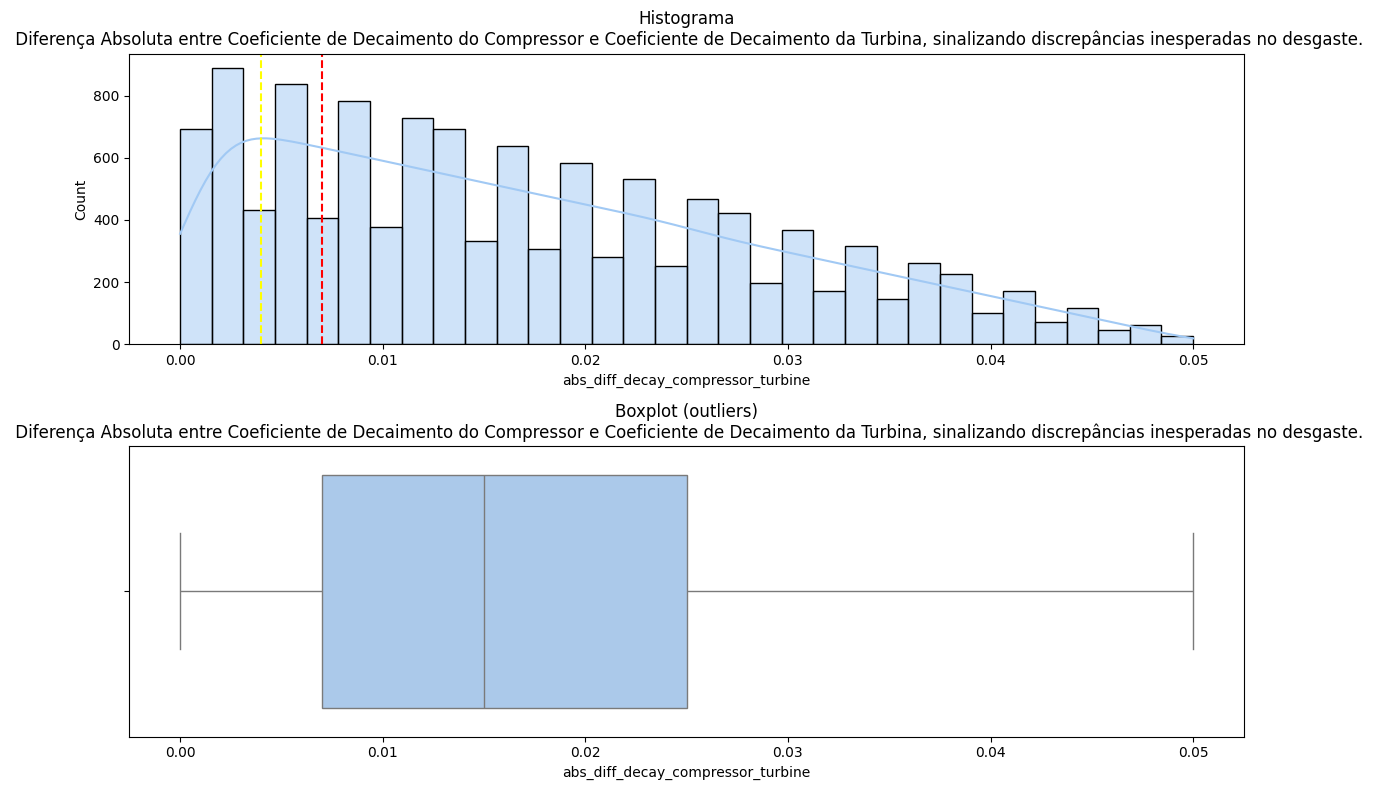

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
ax[0].set_title(f'Histograma\n {titles_features[target_column]}')
sns.histplot(data=df_feature, x=target_column, ax=ax[0], kde=True)
ax[0].axvline(df_feature[target_column].quantile(0.14), linestyle='--', color='yellow')
ax[0].axvline(df_feature[target_column].quantile(0.25), linestyle='--', color='red')

ax[1].set_title(f'Boxplot (outliers)\n {titles_features[target_column]}')
sns.boxplot(data=df_feature, x=target_column, ax=ax[1])

plt.tight_layout()
plt.show()


Identificação do threshold utilizado para categorizar a variavel alvo

In [22]:
threshold = df_feature[target_column].quantile(0.25)
threshold

0.007000000000000006

In [23]:
drop_columns = [target_column, 'product_decay_compressor_power_normalized', 'ratio_decay_compressor_turbine', 'normalized_diff_decay_compressor_turbine_velocity']

In [24]:
X = df_feature.drop(columns=drop_columns)
y = df_feature[target_column].apply(lambda x: 0 if x < threshold else 1)

Quantidade de features do dataset (excluindo a variavel alvo e outras features com significado semelhantes)

In [25]:
print(f'Features: {len(X.columns)}')

Features: 11


Separação do dataset em Treino, Teste e Validação

In [26]:
X_train, X_validation, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f'Train: {len(X_train)} - {pd.Series(y_train).value_counts().to_dict()}')
print(f'Test: {len(X_test)} - {pd.Series(y_test).value_counts().to_dict()}')
print(f'Validation: {len(X_validation)} - {pd.Series(y_validate).value_counts().to_dict()}')

Train: 7607 - {1: 5787, 0: 1820}
Test: 2536 - {1: 1933, 0: 603}
Validation: 1791 - {1: 1361, 0: 430}


Identificação do desbalanceamento de dados com base na variavel alvo

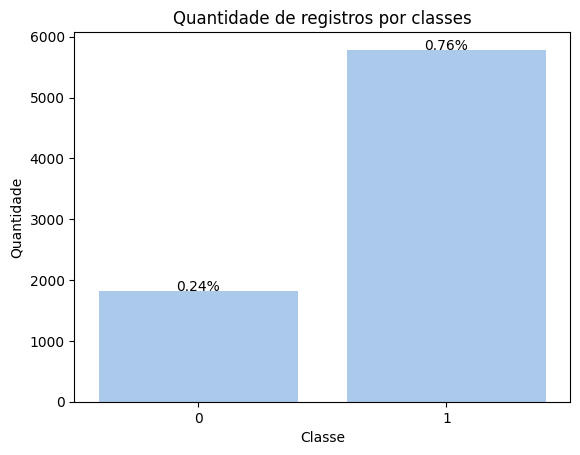

In [27]:
plt.title('Quantidade de registros por classes')
ax = sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts())

for p in ax.patches:
    ax.annotate(str(f'{(p.get_height()/len(y_train)):0.2f}%'),
                xy=(p.get_x() + (p.get_width() / 2.), p.get_height()),
                ha='center')
    
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

### Primeira hipotese: 

Equilibrar o dataset utilizando a geração de dados sintéticos com base nas features da variavel alvo com menor quantidade de registros a fim de equilibra o dataset

In [28]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [29]:
print(f'Train Smote: {len(X_train_smote)} - {pd.Series(y_train_smote).value_counts().to_dict()}')

Train Smote: 11574 - {1: 5787, 0: 5787}


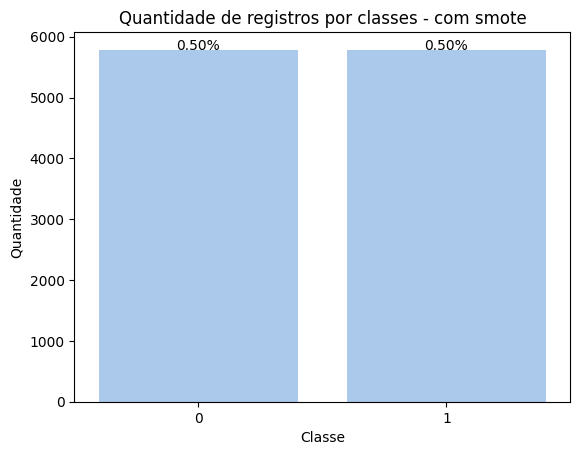

In [30]:
plt.title('Quantidade de registros por classes - com smote')
ax = sns.barplot(x=y_train_smote.value_counts().index, y=y_train_smote.value_counts())

for p in ax.patches:
    ax.annotate(str(f'{(p.get_height()/len(y_train_smote)):0.2f}%'),
                xy=(p.get_x() + (p.get_width() / 2.), p.get_height()),
                ha='center')
    
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

Aplicando PCA para diminuir a quantidade de features do dataset analisando a quantidade de componentes necessárias para ter uma maior variância explicada pelos componentes

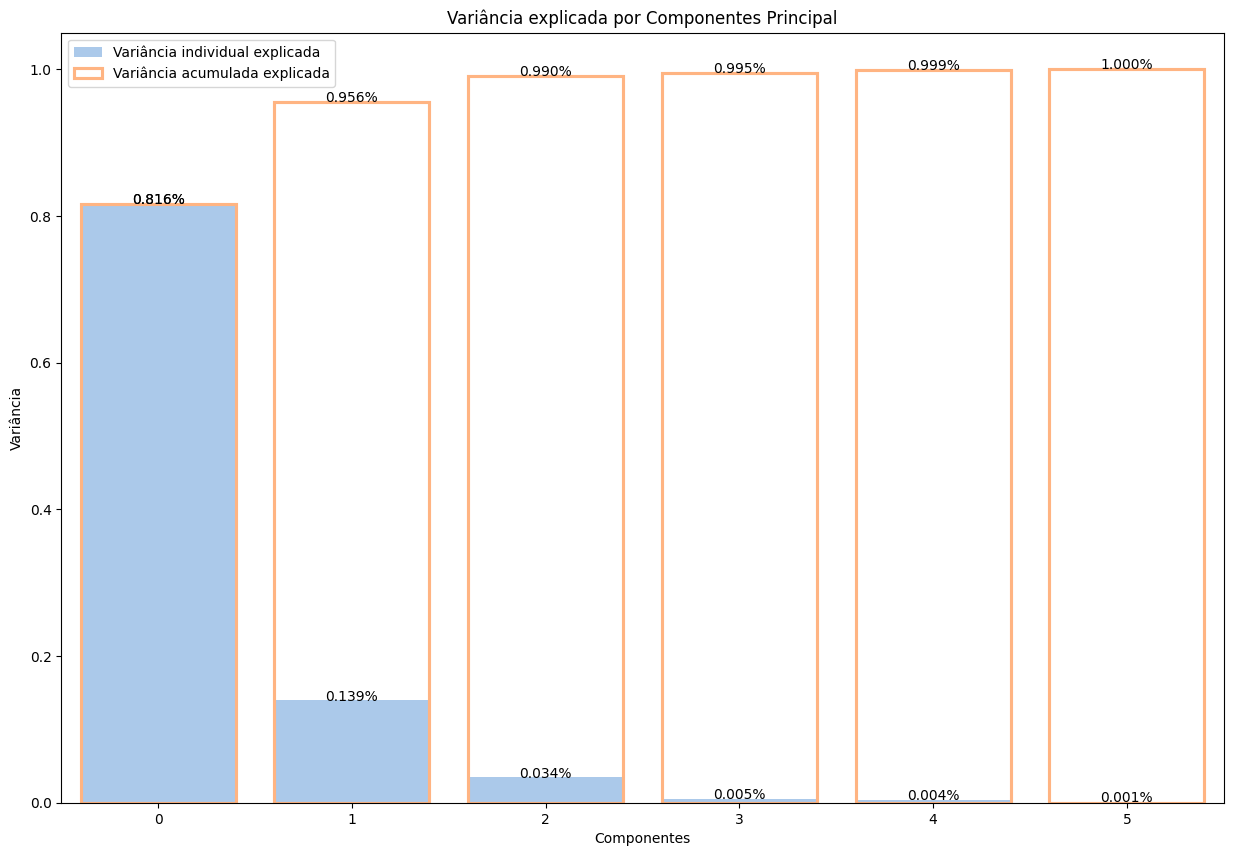

In [31]:
scaler = StandardScaler()
x_train_smote_scaled = scaler.fit_transform(X_train_smote)

pca = PCA(n_components=6)
x_train_smote_component = pca.fit_transform(x_train_smote_scaled)

explaned_components = pca.explained_variance_ratio_
sum_explained_components = np.cumsum(explaned_components)
sum_explained_components

fig, ax= plt.subplots(figsize=(15,10))
plt.title('Variância explicada por Componentes Principal')
sns.barplot(x=range(0, len(explaned_components)), y= explaned_components, label='Variância individual explicada', ax=ax)
sns.barplot(x=range(0, len(sum_explained_components)), y=sum_explained_components, fill=False, label='Variância acumulada explicada', ax=ax)

for p in ax.patches:
    ax.annotate(str(f'{p.get_height():0.3f}%'),
                xy=(p.get_x() + (p.get_width() / 2.), p.get_height()),
                ha='center')
    
plt.xlabel('Componentes')
plt.ylabel('Variância')
plt.legend(loc='best')
plt.show()

Dispersão dos dados dos primeiros dois componentes principal classificados pela variavel alvo

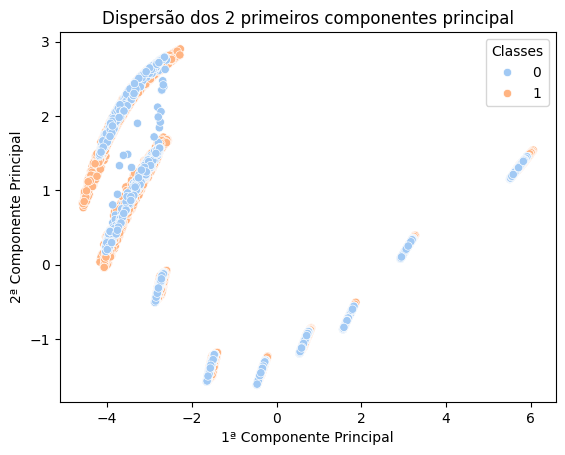

In [32]:
plt.title('Dispersão dos 2 primeiros componentes principal')
sns.scatterplot(x=x_train_smote_component[:,0], y=x_train_smote_component[:,1], hue=y_train_smote)
plt.xlabel('1ª Componente Principal')
plt.ylabel('2ª Componente Principal')
plt.legend(title='Classes')
plt.show()

Criação de diversos modelos a fim de identificar um modelo que poderia ser utilizado como modelo inicial

In [33]:
models = [
    { 'type': 'svc', 'model': SVC() },
    { 'type': 'tree', 'model': DecisionTreeClassifier() },
    { 'type': 'ensemble', 'model': RandomForestClassifier() },
    { 'type': 'logistic', 'model': LogisticRegression() },
    { 'type': 'mlp', 'model': MLPClassifier(max_iter=500) }
]
results = []

Treinamento e validação dos modelos utilizando a técnica de cross validation (Utiliza 1 parte de 5 do dataset de treinamento para validar o modelo, a fim de evitar que o modelo sofra de overfiting - memorização)

In [34]:
for model in models:
    print(f'Execute train to {model["type"]}')
    score = cross_validate(model['model'], x_train_smote_component, y_train_smote, cv = 5)
    results.append(dict(type=model['type'], score=np.mean(score['test_score'])))
pd.DataFrame(results)

Execute train to svc
Execute train to tree
Execute train to ensemble
Execute train to logistic
Execute train to mlp


d:\Repositories\Pessoal\AnaliseNaval\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Repositories\Pessoal\AnaliseNaval\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Repositories\Pessoal\AnaliseNaval\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Repositories\Pessoal\AnaliseNaval\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


type     score
0       svc  0.705548
1      tree  0.942544
2  ensemble  0.956281
3  logistic  0.596942
4       mlp  0.817524

Modelo que melhor performou: RandomForestClassifier (ensemble)

Utilização do método de GridSearch para pesquisar os melhores parametros com base em um subset de parametros aplicando cross validation

In [35]:
params = { 'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': ['balanced', 'balanced_subsample'] }
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, n_jobs=-1)

In [36]:
grid_search.fit(x_train_smote_component, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Melhores parametros encontrados

In [37]:
grid_search.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Score gerado durante a pesquisa

In [38]:
X_test_scaled = scaler.transform(X_test)
X_test_component = pca.transform(X_test_scaled)
grid_search.best_estimator_.score(X_test_component, y_test)

0.9357255520504731

Criação de um modelo com os parâmetros identificados

In [39]:
baseline = RandomForestClassifier(**grid_search.best_params_, random_state=42)
baseline.fit(x_train_smote_component, y_train_smote)
base_predict = baseline.predict(x_train_smote_component)
print(pd.DataFrame(confusion_matrix(y_train_smote, base_predict)))
print('')
print(classification_report(y_train_smote, base_predict))

      0     1
0  5787     0
1     0  5787

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5787
           1       1.00      1.00      1.00      5787

    accuracy                           1.00     11574
   macro avg       1.00      1.00      1.00     11574
weighted avg       1.00      1.00      1.00     11574



O modelo performou 100% nos dados de testes. Aqui podemos estar sofrendo de overfiting (memorização dos dados). Cabe analisarmos como o modelo se sairá nos dados de Teste e Validação. Se não houver uma queda muito grande na performance isso pode indicar que o modelo realmente teve uma capacidade de aprendizado e conseguiu generalizar.

In [40]:
test_predict = baseline.predict(X_test_component)

print(pd.DataFrame(confusion_matrix(y_test, test_predict)))
print('')
print(classification_report(y_test, test_predict))

     0     1
0  560    43
1  116  1817

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       603
           1       0.98      0.94      0.96      1933

    accuracy                           0.94      2536
   macro avg       0.90      0.93      0.92      2536
weighted avg       0.94      0.94      0.94      2536



In [45]:
X_validation_scaled = scaler.transform(X_validation)
X_validation_component = pca.transform(X_validation_scaled)

In [46]:
validation_predict = baseline.predict(X_validation_component)

print(pd.DataFrame(confusion_matrix(y_validate, validation_predict)))
print('')
print(classification_report(y_validate, validation_predict))

     0     1
0  397    33
1   71  1290

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       430
           1       0.98      0.95      0.96      1361

    accuracy                           0.94      1791
   macro avg       0.91      0.94      0.92      1791
weighted avg       0.94      0.94      0.94      1791



O modelo conseguiu manter um padrão de 94% na acurácia tanto em treino quanto teste. Isso pode indicar que o modelo não está sofrendo de overfiting por não ter tido uma diferença muito grande. Poderiamos também utilizar um teste estatistico para comparar as médias entre os modelos para validar se há diferença significativa ou não.

### Segunda hipotese: 

Equilibrar o dataset utilizando a abordagem de downsampling, ou seja, nivelar a quantidade de registro com base na variavel alvo com menor quantidade de registros

In [47]:
y.value_counts()

abs_diff_decay_compressor_turbine
1    9081
0    2853
Name: count, dtype: int64

In [48]:
under_random = RandomUnderSampler(random_state=42)
X_under, y_under = under_random.fit_resample(X, y)

In [49]:
print(f'Train Under: {len(X_under)} - {pd.Series(y_under).value_counts().to_dict()}')

Train Under: 5706 - {0: 2853, 1: 2853}


Criação das variaveis de treino, teste e validação com base no dataset reduzido

In [50]:
X_train, X_validation, y_train, y_validate = train_test_split(X_under, y_under, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f'Train: {len(X_train)} - {pd.Series(y_train).value_counts().to_dict()}')
print(f'Test: {len(X_test)} - {pd.Series(y_test).value_counts().to_dict()}')
print(f'Validation: {len(X_validation)} - {pd.Series(y_validate).value_counts().to_dict()}')

Train: 3637 - {1: 1827, 0: 1810}
Test: 1213 - {1: 610, 0: 603}
Validation: 856 - {0: 440, 1: 416}


Ajuste das variaveis utilizando os mesmos processos de re-escala dos dados (StandardScale) e redução de dimensionalidade (PCA)

In [52]:
scaler = StandardScaler()
x_train_under_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=6)
x_train_under_component = pca.fit_transform(x_train_under_scaled)

Utilizando os mesmos parametros encontrados na pesquisa com gridsearch anteriormente para esse novo modelo. Como a quantidade de dados continua o mesmo, vamos seguir com a hipotese de utilizar os mesmos hyper-parâmetros

In [53]:
baseline = RandomForestClassifier(**grid_search.best_params_, random_state=42)
baseline.fit(x_train_under_component, y_train)
base_predict = baseline.predict(x_train_under_component)
print(pd.DataFrame(confusion_matrix(y_train, base_predict)))
print('')
print(classification_report(y_train, base_predict))

      0     1
0  1810     0
1     0  1827

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1810
           1       1.00      1.00      1.00      1827

    accuracy                           1.00      3637
   macro avg       1.00      1.00      1.00      3637
weighted avg       1.00      1.00      1.00      3637



In [54]:
X_test_scaled = scaler.transform(X_test)
X_test_component = pca.transform(X_test_scaled)

In [55]:
test_predict = baseline.predict(X_test_component)

print(pd.DataFrame(confusion_matrix(y_test, test_predict)))
print('')
print(classification_report(y_test, test_predict))

     0    1
0  581   22
1   61  549

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       603
           1       0.96      0.90      0.93       610

    accuracy                           0.93      1213
   macro avg       0.93      0.93      0.93      1213
weighted avg       0.93      0.93      0.93      1213



In [56]:
X_validate_scaled = scaler.transform(X_validation)
X_validate_component = pca.transform(X_validate_scaled)

In [57]:
validation_predict = baseline.predict(X_validate_component)

print(pd.DataFrame(confusion_matrix(y_validate, validation_predict)))
print('')
print(classification_report(y_validate, validation_predict))

     0    1
0  426   14
1   53  363

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       440
           1       0.96      0.87      0.92       416

    accuracy                           0.92       856
   macro avg       0.93      0.92      0.92       856
weighted avg       0.93      0.92      0.92       856



Em termos gerais os modelos tiveram uma performance no geral muito similares, porém o treinamento utilizando o a abordagem de under sampling se mostrou mais equilibrado quando se observa as outras métricas (precisão, recal, f1-score). Podemos utilizar a métrica de UAC para ter uma melhor comparativo entre os modelos, mas se tratando do mesmo algoritmo (RandomForest), vamos seguir com essa segunda opção.